In [1]:
# sources: 
# https://jsdokken.com/dolfinx-tutorial/chapter2/heat_equation.html
# https://fenicsproject.org/pub/tutorial/html/._ftut1006.html
# https://fenicsproject.org/pub/course/lectures/2012-11-rognes-kaust-sa/lecture_04_time_dependent_pdes.pdf

# Solving heat equation PDE 

### Dynamic Poisson equation = "Heat equation"

$\left\{ 
\begin{array}
    &∂u/∂t − ∆u=f& \mbox{in Ω}\\
    u=0& \mbox{on ∂Ω (Dirichlet boundary conditions)}\\
    u=u0& \mbox{at t=0}\\
  \end{array}
  \right.$

### Problem to solve 

In [2]:
# Time discretization (Backward Euler method applied on ∂u/∂t)
# Initialize spatial discretization of the PDE

Find u∈V such that: 
 
$\left\{ 
\begin{array}
    &\int_{Ω}^{} (u·v + Δt∇u·∇v) dx = \int_{Ω}^{} (u^{n} + Δtf^{n+1}).v dx,& \mbox{∀v∈V}\\
    u=0& \mbox{on ∂Ω (Dirichlet boundary conditions)}\\
    u=u0& \mbox{at t=0}\\
  \end{array}
  \right.$
  
N.B. The method used to discretize in time ∂u/∂t and reinject it into the variational form: backward Euler (implicit Euler discretization). u=$u^{n+1}$

### Principles of resolution with FEM 

The Finite Element Method (ex: FEniCS) provides a solution 'uh' that approximates the real solution 'u'.
The precision of uh depends on the number of basis functions (finite elements) considered and on their on their degree.

Here:
- u=$u^{n+1}$ ~ uh=Σαi.φi. φi are N basis functions used to discretize the spatial domain and solve the equation. φi are choosen to be orthogonal. αi are the new N unknowns at each time step.
- v is choosen as a "test function" equal to φj. It enables to get N independant equations

The Finite Element Method uses the variational form to express the equation into a linear matrix problem: AU = L (linear variational problem in terms of 'u')

# Resolution with FEniCS (Finite Element Method library)

In [3]:
import fenics

### Define domain

In [4]:
mesh = fenics.UnitSquareMesh(32, 32) # FEniCS mesh object

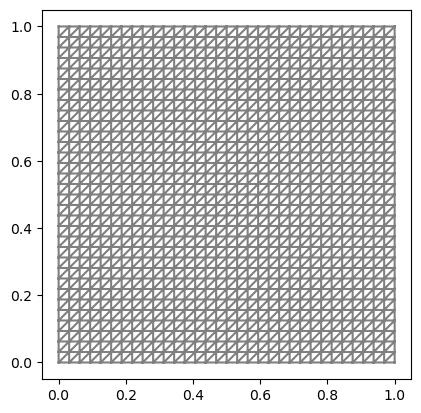

In [5]:
fenics.plot(mesh)

### Define the space of basis functions to discretize the spatial domain

In [6]:
# "Function Space": space of all basis functions (i.e. finite elements) used to approximate the real solution 'u'

In [7]:
V = fenics.FunctionSpace(mesh, "Lagrange", 1) # family of functions --> Lagrange; degree --> 1 (linear polynome)

### Trial and test functions

In [8]:
# "Function": composition of the finite basis functions in V

In [9]:
u_trial = fenics.TrialFunction(V) # trial function standing for 'uh' approximation -->  Σαi*φi 
v_test = fenics.TestFunction(V) # test function -->  φj

### Other functions of the basis function space V

In [10]:
u_n = fenics.Function(V) # initialize un

### Temporal discretization parameters

In [11]:
T = 1.0 
num_steps = 10   
dt = T / num_steps 

### Variational form

$\int\limits_\Omega (u·v + Δt∇u·∇v) dx = \int\limits_\Omega (u^{n} + Δtf^{n+1}).v dx$

with:
- $a(u,v)$ = $\int\limits_\Omega (u·v + Δt∇u·∇v) dx$ (bilinear form)

- $L(v)$ = $\int\limits_\Omega (u^{n} + Δtf^{n+1}).v dx$ (linear form)

#### bilinear form a(u_trial,v_test)

In [12]:
# a(u_trial,v_test) is part of the variational form depending on the 'uh' solution

In [13]:
a = u_trial*v_test*fenics.dx + dt*fenics.dot(fenics.grad(u_trial), fenics.grad(v_test))*fenics.dx

#### linear form L(v_test) 

In [14]:
# L(v_test) is part of the variational form independant from the 'uh' solution

In [15]:
# Initialize u_n
#u_n0 = fenics.Expression('(pow(x[0] - xCenter, 2) + pow(x[1] - yCenter, 2))/pow(width, 2)', xCenter=0.2, yCenter=0.2, width=0.05, degree=2)
#u_n0 = fenics.Constant(1.)

import math
pi = math.pi
u_n0  = fenics.Expression('coef * sin(4*pi*x[0]) * sin(4*pi*x[1])', pi=pi, degree=1, coef=1)
u_n = fenics.interpolate(u_n0 , V) 

In [16]:
#source_ext = fenics.Expression("x[0]*x[1]", degree=4)
#source_ext = fenics.Expression('-(pow(x[0] - xCenter, 2) + pow(x[1] - yCenter, 2))/pow(width, 2)', xCenter=0.8, yCenter=0.8, width=0.1, degree=2)
#source_ext = fenics.project(fenics.Constant((0.)), V)

#import math
#pi = math.pi
#f = fenics.Expression('coef * sin(4*pi*x[0]) * sin(4*pi*x[1])', pi=pi, degree=1, coef=1)
f = fenics.Constant(0.)

In [17]:
L = (u_n + dt*f)*v_test*fenics.dx

### Define Dirichlet boundary conditions

In [18]:
bc = fenics.DirichletBC (V, 0.0, fenics.DomainBoundary()) # boundaries are fixed

### Solver

In [19]:
# Prepare results export
uh_xdmf = fenics.XDMFFile('./uh.xdmf')
uh_xdmf.parameters["flush_output"] = True
uh_xdmf.parameters["functions_share_mesh"] = True
uh_xdmf.parameters["rewrite_function_mesh"] = True 

In [20]:
uh = fenics.Function(V) # 'uh' is the approximation with FEM/FEniCS of real solution 'u'

# Timestepping Loop 
import vedo.dolfin
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

t = 0
times = [0]
#uh_xdmf.write_checkpoint(fenics.project(uh, V), "uh", 0, append=False) 

for n in range(num_steps):

    # Update current time
    t += dt
    times.append(t)

    # Solve linear variational problem
    fenics.solve(a == L, uh, bc)
    
    # Write update of uh on the export file
    uh_xdmf.write_checkpoint(fenics.project(uh,V), "uh", t, append=True)
    
    # Update previous solution
    u_n.assign(uh)
    
    plt.pause(0.1)

uh_xdmf.close()

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


### Visualization

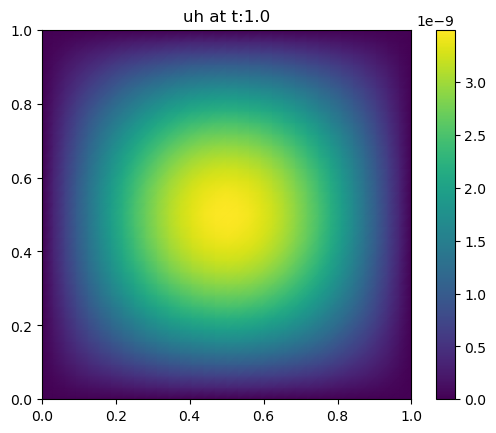

In [30]:
from IPython.display import clear_output

uh_timeserie =  fenics.XDMFFile("./uh.xdmf") 
uh_t = fenics.Function(V) 

for i,t in enumerate(times[1:]):
    uh_timeserie.read_checkpoint(uh_t, "uh", i) 
    t = float(f"{t:.1f}")
    fenics.plot(uh_t, title="uh at t:{}".format(t)) 
    #vedo.dolfin.plot(uh, text="uh at t:{}".format(t), style='paraview', interactive=False).close() # extra rendering window
    c = fenics.plot(fenics.interpolate(uh_t, V), mode='color')
    plt.colorbar(c)
    plt.show()
    clear_output(wait=True) # update uh on the same window
    plt.pause(2.)

In [23]:
len(times)

11

In [24]:
uh_t

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Lagrange', triangle, 1)), 291)

In [28]:
uh_t.vector()[:]

array([ 0., -0.,  0., ...,  0.,  0., -0.])